In [28]:
import sys
sys.path.append('..')

In [29]:
from flax import linen as nn

from jaxmetalog import LogitMetalog

from statsmodels.distributions import ECDF


import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt

In [30]:
key = jax.random.PRNGKey(30091985)

In [31]:
map_s_to_s = {
    (2, 3): (10, 1),
    (9, 5): (30, 1),
    (1, 1): (1, 10)
}   

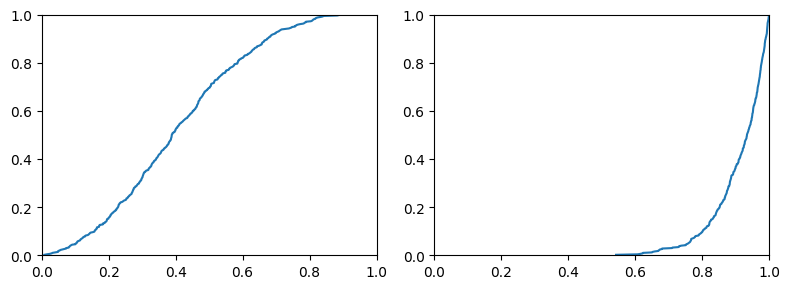

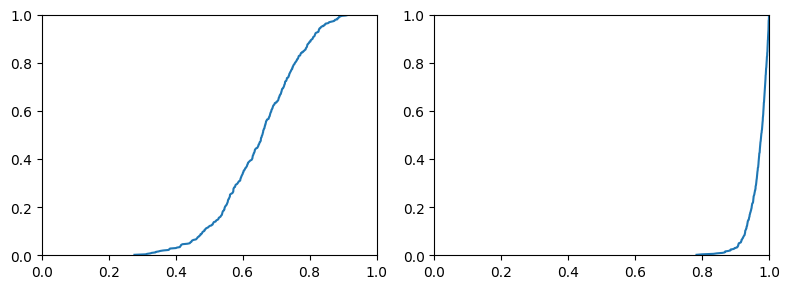

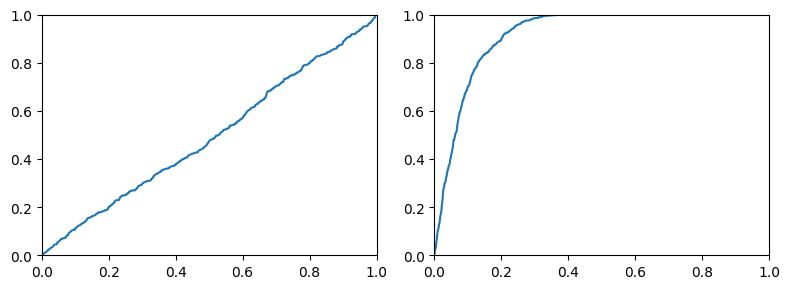

In [32]:
for src, dest in map_s_to_s.items():
    a_src, b_src = src
    a_dst, b_dst = dest
    
    key, sub = jax.random.split(key)
    src_data = jax.random.beta(sub, a_src, b_src, shape=(500, ))

    key, sub = jax.random.split(key)
    dst_data = jax.random.beta(sub, a_dst, b_dst, shape=(500, ))

    fig, ax = plt.subplots(1, 2, figsize=(8, 3))
    ecdf_src = ECDF(src_data)
    ecdf_dst = ECDF(dst_data)

    ax[0].plot(ecdf_src.x, ecdf_src.y)
    ax[1].plot(ecdf_dst.x, ecdf_dst.y)

    ax[0].set(xlim=(0, 1), ylim=(0, 1))
    ax[1].set(xlim=(0, 1), ylim=(0, 1))
    
    fig.tight_layout()
    plt.show()
    plt.close()

In [33]:
nt = len(map_s_to_s)
D_src = jnp.zeros(shape=(nt, 20, 500))
D_dst = jnp.zeros(shape=(nt, 20, 500))

t = 0
for src, dest in map_s_to_s.items():
    a_src, b_src = src
    a_dst, b_dst = dest

    for i in range(20):
        key, sub = jax.random.split(key)
        src_data = jax.random.beta(sub, a_src, b_src, shape=(500, ))

        key, sub = jax.random.split(key)
        dst_data = jax.random.beta(sub, a_dst, b_dst, shape=(500, ))

        D_src = D_src.at[t, i].set(src_data)
        D_dst = D_dst.at[t, i].set(dst_data)
    t = t + 1

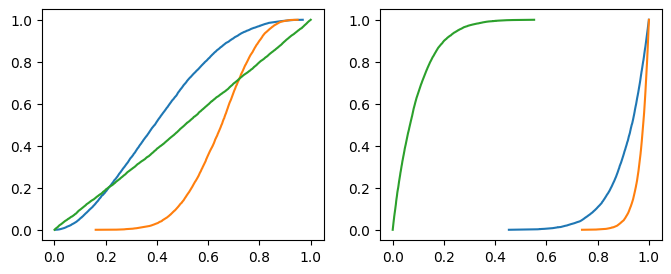

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
for t in range(3):
    ecdf = ECDF(D_src[t].ravel())
    ax[0].plot(ecdf.x, ecdf.y)

    ecdf = ECDF(D_dst[t].ravel())
    ax[1].plot(ecdf.x, ecdf.y)

In [35]:
w_xs = []
w_ys = []

for t in range(3):
    for i in range(20):
        dist = LogitMetalog(0, 1)
        dist.fit(D_src[t, i])
        w_x = dist._weights

        w_xs.append(w_x)
        
        dist = LogitMetalog(0, 1)
        dist.fit(D_dst[t, i])
        w_y = dist._weights

        w_ys.append(w_y)

In [36]:
max_size = max(
    max(map(lambda l: len(l), w_xs)),
    max(map(lambda l: len(l), w_ys))
)
max_size

7

In [37]:
X = jnp.zeros(shape=(60, max_size))
Y = jnp.zeros(shape=(60, max_size))

for i in range(60):
    w_x = w_xs[i]
    k = len(w_x)
    X = X.at[i, :k].set(w_x)

    w_y = w_ys[i]
    k = len(w_y)
    Y = Y.at[i, :k].set(w_y)

In [38]:
key, sub = jax.random.split(key)
idx = jnp.arange(X.shape[0])
idx = jax.random.permutation(sub, idx, independent=True)

X = X[idx]
Y = Y[idx]

In [39]:
from jax import Array
from typing import Sequence

class Net(nn.Module):
    layers: Sequence[int]
    final_size: int

    @nn.compact
    def __call__(self, X: Array) -> Array:
        a = X
        for size in self.layers:    
            z = nn.Dense(size)(a)
            a = nn.relu(z)
        return nn.Dense(self.final_size)(a)

In [40]:
model = Net([8, 8, 8, 8], max_size)

key, sub = jax.random.split(key)
init_params = model.init(sub, X)

In [41]:
model.apply(init_params, X).shape

(60, 7)

In [42]:
Y.shape

(60, 7)

In [43]:
@jax.jit
def mse(params, X, Y):
    Y_hat = model.apply(params, X)
    return jnp.power(Y - Y_hat, 2).mean()

grad = jax.grad(mse)

In [44]:
mse(init_params, X, Y)

Array(1.6008741, dtype=float32)

In [45]:
grad(init_params, X, Y)

{'params': {'Dense_0': {'bias': Array([-0.08032253,  0.10682827, -0.11311362,  0.01449232,  0.04931411,
           0.        ,  0.04508419, -0.03265563], dtype=float32),
   'kernel': Array([[-1.2238433e-04, -1.1390003e-02,  1.1187362e-02, -3.2981792e-03,
            7.3956554e-03,  0.0000000e+00,  2.3183182e-02, -4.4404166e-03],
          [-6.9096327e-02,  1.5520336e-01, -1.7318626e-01,  2.0655010e-02,
            6.2409785e-02,  0.0000000e+00,  7.8279004e-03, -7.7437661e-03],
          [ 1.2948166e-02, -1.9674616e-02,  2.0903563e-02, -2.8314518e-03,
           -7.5267688e-03,  0.0000000e+00, -3.8520063e-03,  4.3926444e-03],
          [-5.8578171e-02,  6.0851641e-02, -6.2189698e-02,  8.1281103e-03,
            3.0822322e-02,  0.0000000e+00,  3.9484821e-02, -2.9263377e-02],
          [-6.7571521e-02,  9.1372073e-02, -9.7044945e-02,  1.2285333e-02,
            4.2324360e-02,  0.0000000e+00,  3.7968997e-02, -2.7115634e-02],
          [ 2.2523752e-03, -2.8142631e-02,  3.1625848e-02, -6.545

In [46]:
import optax

params = init_params
optimizer = optax.adam(learning_rate=1e-2)
opt_state = optimizer.init(params)

In [47]:
for i in range(500):
    grads = grad(params, X, Y)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)

    loss = mse(params, X, Y)
    print(i, loss)

0 1.5233765
1 1.4630766
2 1.4078779
3 1.3519398
4 1.2920657
5 1.2270321
6 1.1556442
7 1.0833988
8 1.0174696
9 0.96311677
10 0.91913277
11 0.87818736
12 0.83388096
13 0.7845693
14 0.7350911
15 0.6903447
16 0.6542414
17 0.6281475
18 0.6087508
19 0.58467877
20 0.5577386
21 0.5390569
22 0.52681404
23 0.5076108
24 0.48034757
25 0.45852947
26 0.44595733
27 0.43796352
28 0.42955193
29 0.42055526
30 0.41459998
31 0.41241345
32 0.4101616
33 0.40488476
34 0.3965144
35 0.38892004
36 0.38210246
37 0.3743087
38 0.36498192
39 0.35510167
40 0.34627432
41 0.3391813
42 0.33301407
43 0.32660508
44 0.31988817
45 0.31362268
46 0.30798048
47 0.30207443
48 0.2951446
49 0.28753194
50 0.28014073
51 0.27329028
52 0.26652384
53 0.2594981
54 0.25250632
55 0.245878
56 0.23940033
57 0.23260209
58 0.22533451
59 0.21790689
60 0.2104718
61 0.20293702
62 0.19522274
63 0.18753776
64 0.1800505
65 0.1726305
66 0.16506658
67 0.15741295
68 0.14980602
69 0.14215462
70 0.13435955
71 0.12655596
72 0.118860155
73 0.1112128
74 

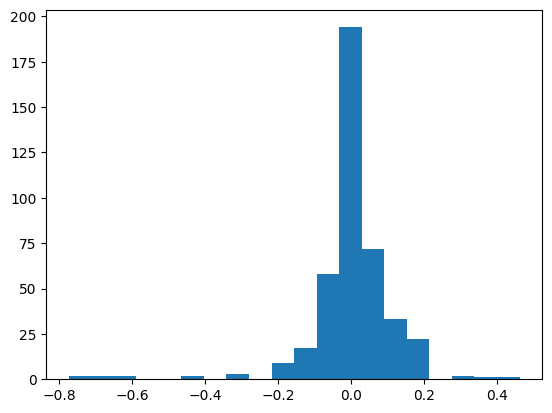

In [48]:
Y_hat = model.apply(params, X)
plt.hist((Y_hat - Y).ravel(), bins=20);

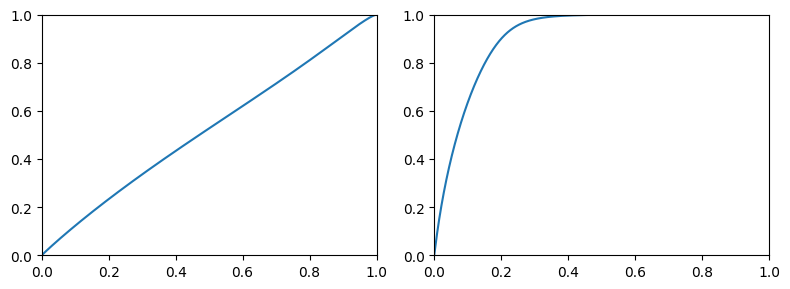

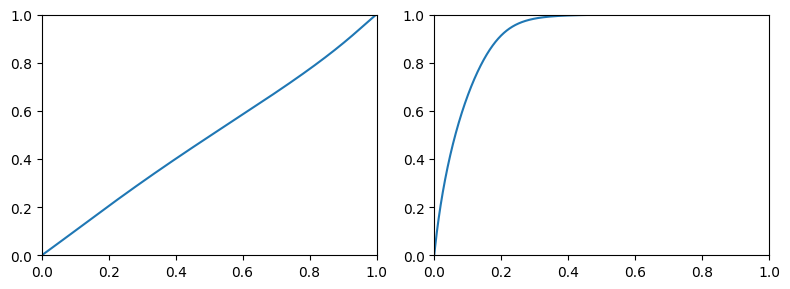

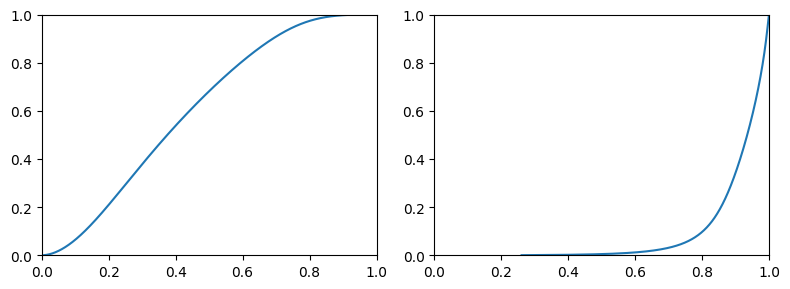

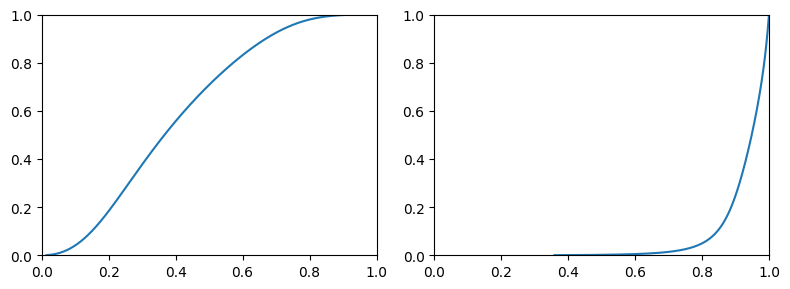

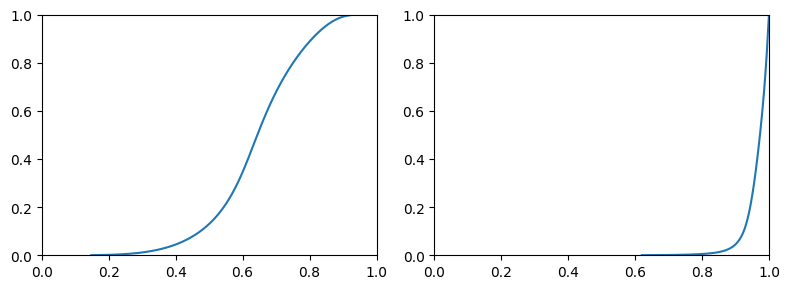

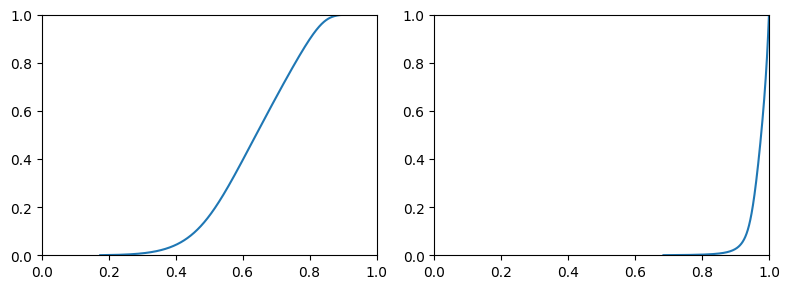

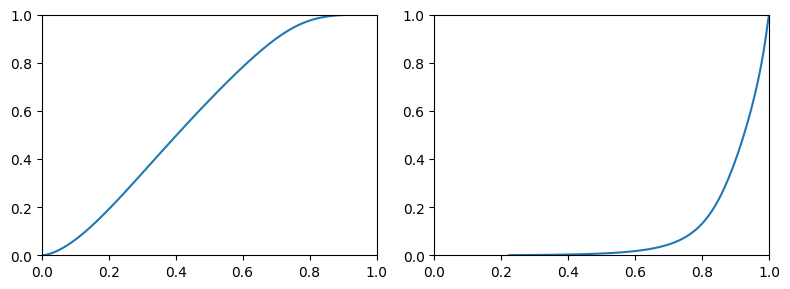

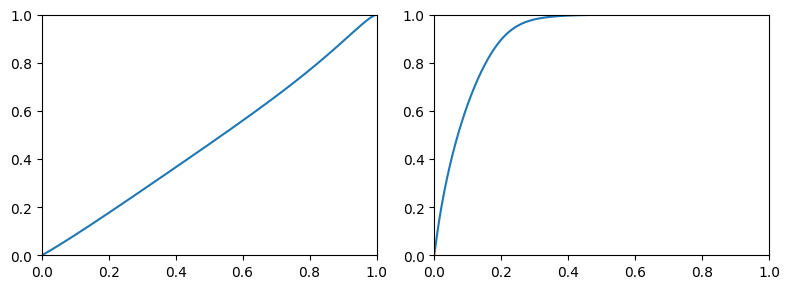

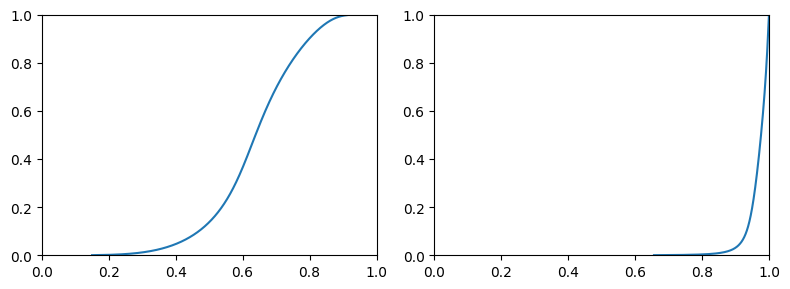

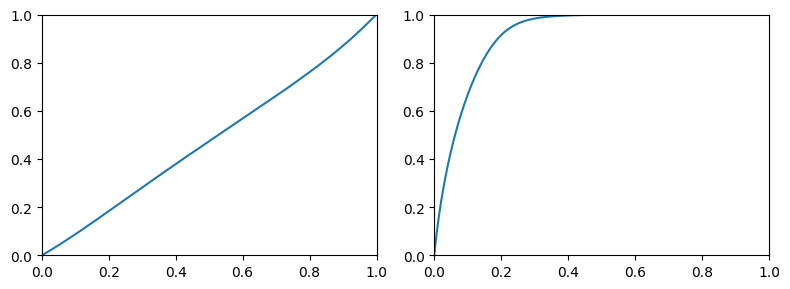

In [49]:
data = jnp.linspace(0.0001, 0.9999, 2000)

for i in range(10):
    fig, ax = plt.subplots(1, 2, figsize=(8, 3))

    dist_src = LogitMetalog(0, 1)
    dist_src._weights = X[i]

    dist_dst = LogitMetalog(0, 1)
    dist_dst._weights = Y_hat[i]

    meta_x_src, meta_y_src = dist_src.ppf(data)
    meta_x_dst, meta_y_dst = dist_dst.ppf(data)

    ax[0].plot(meta_x_src, meta_y_src)
    ax[1].plot(meta_x_dst, meta_y_dst)

    ax[0].set(xlim=(0, 1), ylim=(0, 1))
    ax[1].set(xlim=(0, 1), ylim=(0, 1))
    
    fig.tight_layout()
    plt.show()
    plt.close()